# Convolutional Neural Network

### Part 1 - Building the CNN

#### Importing the Tensorflow libraries and packages

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.5
Scikit-Learn 1.0.2
GPU is available


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import os

##  ResNet50 

In [3]:
import tensorflow.keras as keras

resnet50 = keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False)
conv_model.summary()

94773248/94765736 [==============================] - 35s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_________________________

In [4]:
import matplotlib.pyplot as plt
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    path_dir = '../dataset_mel_final/train'
    parth_dir_test = '../dataset_mel_final/test'

    datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split = 0.2)

    train_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(224,224),
        shuffle=True,
        subset='training',
        batch_size = 64,
        class_mode = 'binary'
    )
    
    val_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(224,224),
        subset='validation',
        batch_size = 64,
        class_mode = 'binary'
    )

    test_dataset = datagen.flow_from_directory(parth_dir_test,
                                        target_size=(224,224),
                                        batch_size =64,
                                        class_mode = 'binary')
    return train_dataset, val_dataset, test_dataset

In [6]:
train_dataset, val_dataset, test_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 1102 images belonging to 2 classes.
Found 274 images belonging to 2 classes.
Found 344 images belonging to 2 classes.


In [10]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [11]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)


# final softmax layer with 250 categories
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
for layer in conv_model.layers:
    layer.trainable = False

In [13]:
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    epochs=30
)

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
18/18 [==============================] - 16s 431ms/step - loss: 0.7166 - acc: 0.5118 - val_loss: 0.6197 - val_acc: 0.5000
Epoch 2/30
18/18 [==============================] - 5s 245ms/step - loss: 0.5818 - acc: 0.7269 - val_loss: 0.5262 - val_acc: 0.8102
Epoch 3/30
18/18 [==============================] - 5s 258ms/step - loss: 0.5018 - acc: 0.7985 - val_loss: 0.4166 - val_acc: 0.8942
Epoch 4/30
18/18 [==============================] - 5s 248ms/step - loss: 0.4480 - acc: 0.8230 - val_loss: 0.3665 - val_acc: 0.8832
Epoch 5/30
18/18 [==============================] - 5s 258ms/step - loss: 0.4341 - acc: 0.8276 - val_loss: 0.3482 - val_acc: 0.8723
Epoch 6/30
18/18 [==============================] - 5s 256ms/step - loss: 0.4409 - acc: 0.8131 - val_loss: 0.3404 - val_acc: 0.8942
Epoch 7/30
18/18 [==============================] - 5s 245ms/step - loss: 0.4152 - acc: 0.8303 - val_loss: 0.3202 - val_acc: 0.9015
Epoch 8/30
18/18 [==============================] - 5s 245ms/step - loss: 0

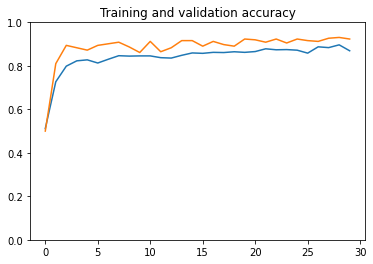

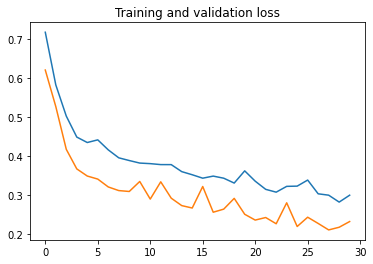

In [16]:
plot_history(history, yrange=(0,1))

In [17]:
score = full_model.evaluate(test_dataset, verbose=0)

print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 0.29819872975349426
Test accuracy 0.8720930218696594


In [ ]:
#ResNet18